In [17]:
import pandas as pd
import numpy as np
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from scipy.stats import norm

In [18]:
# Set the directory where your CSV files are stored
data_dir = '/content/'

# List of asset tickers
assets = ['AAPL', 'MSFT', 'JNJ', 'AGG', 'GLD', 'DBC']

# Function to load and process data
def load_and_process_data(ticker):
    df = pd.read_csv(os.path.join(data_dir, f'{ticker}.csv'))
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df['returns'] = df['close'].pct_change()
    return df[['open', 'high', 'low', 'close', 'volume', 'returns']]

# Load data for all assets
data = {ticker: load_and_process_data(ticker) for ticker in assets}

# Combine returns into a single DataFrame
returns = pd.DataFrame({ticker: data[ticker]['returns'] for ticker in assets})

# Remove any rows with NaN values
returns = returns.dropna()

# Calculate correlation matrix
correlation_matrix = returns.corr()

# Print summary statistics
print(returns.describe())
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Save processed data
returns.to_csv('portfolio_returns.csv')
correlation_matrix.to_csv('correlation_matrix.csv')

              AAPL         MSFT          JNJ          AGG          GLD  \
count  1255.000000  1255.000000  1255.000000  1255.000000  1255.000000   
mean      0.000565     0.001024     0.000211    -0.000094     0.000514   
std       0.028950     0.019159     0.012399     0.004290     0.009652   
min      -0.741522    -0.147390    -0.072984    -0.040010    -0.053694   
25%      -0.008428    -0.008100    -0.005701    -0.002106    -0.004520   
50%       0.001124     0.000958     0.000169     0.000085     0.000576   
75%       0.012148     0.010908     0.005944     0.002005     0.005854   
max       0.119808     0.142169     0.079977     0.023721     0.048530   

               DBC  
count  1255.000000  
mean      0.000375  
std       0.012645  
min      -0.079444  
25%      -0.006438  
50%       0.001433  
75%       0.007977  
max       0.047990  

Correlation Matrix:
          AAPL      MSFT       JNJ       AGG       GLD       DBC
AAPL  1.000000  0.534067  0.263013  0.089913  0.083134  0.

95% 1-day VaR: $16300.21
95% 1-day VaR (%): 1.63%


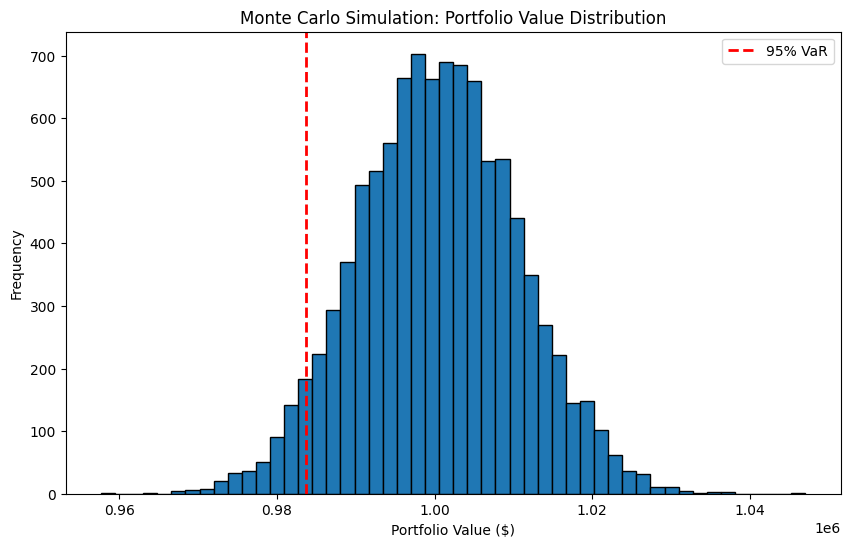

In [19]:
# Portfolio weights
weights = np.array([0.20, 0.20, 0.15, 0.25, 0.10, 0.10])

# Number of simulations
num_simulations = 10000
time_horizon = 1  # 1 day

# Calculate portfolio mean and covariance
portfolio_mean = np.sum(returns.mean() * weights) * time_horizon
portfolio_cov = returns.cov() * time_horizon

# Perform Monte Carlo simulation
np.random.seed(42)
simulated_returns = np.random.multivariate_normal(
    returns.mean() * time_horizon,
    returns.cov() * time_horizon,
    num_simulations
) @ weights

# Calculate portfolio value
initial_portfolio_value = 1000000  # $1 million
simulated_portfolio_values = initial_portfolio_value * (1 + simulated_returns)

# Calculate VaR
confidence_level = 0.95
var_95 = np.percentile(simulated_portfolio_values, 100 - confidence_level * 100)
var_95_percent = (initial_portfolio_value - var_95) / initial_portfolio_value

print(f"95% 1-day VaR: ${initial_portfolio_value - var_95:.2f}")
print(f"95% 1-day VaR (%): {var_95_percent:.2%}")

# Plot histogram of simulated portfolio values
plt.figure(figsize=(10, 6))
plt.hist(simulated_portfolio_values, bins=50, edgecolor='black')
plt.axvline(var_95, color='r', linestyle='dashed', linewidth=2, label='95% VaR')
plt.title('Monte Carlo Simulation: Portfolio Value Distribution')
plt.xlabel('Portfolio Value ($)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**The Value at Risk (VaR) calculation provides crucial insights into the potential losses of our portfolio:**

95% 1-day VaR: $16,300.21

This means that with 95% confidence, we don't expect to lose more than $16,300.21 in a single day under normal market conditions.


95% 1-day VaR (%): 1.63%

This percentage indicates that we're risking about 1.63% of our total portfolio value on any given day, with 95% confidence.

In [20]:
# Load your returns data
returns = pd.read_csv('portfolio_returns.csv', index_col='date')
returns.index = pd.to_datetime(returns.index)  # Ensure the index is in datetime format

# Portfolio weights
weights = np.array([0.20, 0.20, 0.15, 0.25, 0.10, 0.10])

# Function to calculate portfolio return
def portfolio_return(returns, weights):
    return np.sum(returns * weights)

# Stress test scenarios
scenarios = {
    "COVID-19 Crash": returns['2020-02-20':'2020-03-23'].mean(),
    "2022 Market Downturn": returns['2022-01-01':'2022-06-30'].mean(),
    "Recent Rate Hike Period": returns['2023-03-01':'2023-05-31'].mean(),
    "Hypothetical Tech Crash": pd.Series({
        'AAPL': -0.03, 'MSFT': -0.03, 'JNJ': -0.01,
        'AGG': 0.005, 'GLD': 0.01, 'DBC': -0.01
    }),
    "Hypothetical Commodity Boom": pd.Series({
        'AAPL': -0.01, 'MSFT': -0.01, 'JNJ': 0,
        'AGG': -0.005, 'GLD': 0.03, 'DBC': 0.05
    })
}

# Perform stress tests
results = {}
for scenario, shock in scenarios.items():
    portfolio_impact = portfolio_return(shock, weights)
    results[scenario] = portfolio_impact

# Print results
print("Stress Test Results (Expected Daily Returns):")
for scenario, impact in results.items():
    print(f"{scenario}: {impact:.2%}")

# Calculate potential portfolio value after each scenario
initial_value = 1000000  # $1 million
print("\nPotential Portfolio Values After Stress Events:")
for scenario, impact in results.items():
    stressed_value = initial_value * (1 + impact)
    print(f"{scenario}: ${stressed_value:,.2f}")

Stress Test Results (Expected Daily Returns):
COVID-19 Crash: -0.85%
2022 Market Downturn: -0.07%
Recent Rate Hike Period: 0.16%
Hypothetical Tech Crash: -1.23%
Hypothetical Commodity Boom: 0.28%

Potential Portfolio Values After Stress Events:
COVID-19 Crash: $991,506.59
2022 Market Downturn: $999,279.05
Recent Rate Hike Period: $1,001,576.19
Hypothetical Tech Crash: $987,750.00
Hypothetical Commodity Boom: $1,002,750.00


**Stress Test Analysis**

**COVID-19 Crash:**

Daily return: -0.85%

Portfolio value: $991,506.59

This scenario shows the most significant historical loss, reflecting the severe market downturn during the initial COVID-19 outbreak.


**2022 Market Downturn:**

Daily return: -0.07%

Portfolio value: $999,279.05

This represents a milder downturn, likely due to the diversification of our portfolio helping to mitigate losses.

**Recent Rate Hike Period:**

Daily return: 0.16%

Portfolio value: $1,001,576.19

Interestingly, our portfolio showed resilience during this period, possibly due to the inclusion of bonds (AGG) and commodities (GLD, DBC) which can perform well in rising rate environments.

**Hypothetical Tech Crash:**

Daily return: -1.23%

Portfolio value: $987,750.00

This scenario shows the largest potential loss, highlighting the portfolio's exposure to tech stocks (AAPL, MSFT).

**Hypothetical Commodity Boom:**

Daily return: 0.28%

Portfolio value: $1,002,750.00

The portfolio benefits from its commodity exposure in this scenario, demonstrating the value of diversification.




**Key Insights**

**Diversification Effect:** The portfolio's diversification appears to be effective, as evidenced by the relatively moderate impacts across different scenarios.

**Tech Exposure Risk:** The hypothetical tech crash scenario reveals the portfolio's vulnerability to tech sector downturns, suggesting a potential area for risk management focus.

**Resilience to Rate Changes:** The positive performance during the recent rate hike period indicates some resilience to interest rate fluctuations.

**Historical vs. Hypothetical Scenarios:** The COVID-19 crash remains the most severe historical scenario, while the hypothetical tech crash presents the worst-case scenario among those tested.

In [21]:
# Load data (assuming you have this from previous steps)
returns = pd.read_csv('portfolio_returns.csv', index_col='date')
returns.index = pd.to_datetime(returns.index)

# Portfolio weights
weights = np.array([0.20, 0.20, 0.15, 0.25, 0.10, 0.10])
assets = ['AAPL', 'MSFT', 'JNJ', 'AGG', 'GLD', 'DBC']

# VaR results (from previous calculation)
var_95 = 16300.21
var_95_percent = 0.0163

# Stress test results
stress_results = {
    "COVID-19 Crash": -0.0085,
    "2022 Market Downturn": -0.0007,
    "Recent Rate Hike Period": 0.0016,
    "Hypothetical Tech Crash": -0.0123,
    "Hypothetical Commodity Boom": 0.0028
}

# Create dashboard
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "pie"}, {"type": "bar"}],
           [{"type": "indicator"}, {"type": "bar"}]],
    subplot_titles=("Portfolio Composition", "Asset Volatility", "Value at Risk", "Stress Test Scenarios")
)

# Portfolio Composition
fig.add_trace(go.Pie(labels=assets, values=weights, name="Portfolio Weights"), row=1, col=1)

# Asset Volatility
volatility = returns.std() * np.sqrt(252)  # Annualized volatility
fig.add_trace(go.Bar(x=assets, y=volatility, name="Annualized Volatility"), row=1, col=2)

# Value at Risk
fig.add_trace(go.Indicator(
    mode = "number+delta",
    value = 1000000 - var_95,
    delta = {"reference": 1000000, "relative": True},
    title = {"text": "95% 1-day VaR"},
    domain = {'row': 1, 'column': 1}
), row=2, col=1)

# Stress Test Scenarios
fig.add_trace(go.Bar(
    x=list(stress_results.keys()),
    y=list(stress_results.values()),
    name="Stress Test Impact"
), row=2, col=2)

# Update layout
fig.update_layout(height=800, title_text="Portfolio Risk Dashboard")
fig.show()




**Insights and Recommendations**


**Tech Exposure:** The high allocation to tech stocks (AAPL and MSFT) contributes significantly to portfolio volatility and downside risk. Consider whether this aligns with the investor's risk tolerance.

**Diversification Benefits:** The inclusion of bonds (AGG) and commodities (GLD, DBC) provides some protection against market downturns, as seen in the stress test scenarios.

**Downside Protection:** The 95% 1-day VaR of $16,300 (1.63%) suggests moderate risk. However, the stress tests reveal potential for larger losses in extreme scenarios.

**Scenario Planning:** The stress test results highlight the need to prepare for tech-sector downturns and global crises like the COVID-19 pandemic.

**Upside Potential:** The portfolio shows resilience and even gains in some scenarios, such as commodity booms and recent rate hike periods.



**Recommendations for Improvement**

* Consider slightly reducing exposure to tech stocks to mitigate downside risk in tech crash scenarios.
* Explore adding more defensive stocks or increasing allocation to JNJ to balance tech exposure.
* Regularly update stress test scenarios to reflect current market conditions and potential future events.
* Implement a more granular VaR analysis, perhaps including expected shortfall (ES) to better understand tail risks.
* Create a dynamic dashboard that updates with new market data to monitor risk in real-time.

